# Data Understanding

The metrics that will be used to evaluate this stage are:

- **Diversity** of statistical methods and graphs (rich and justified set of methods);

- **Complexity** of statistical methods and graphs (complex and integrated 3+D methods with clear results);

- **Interpretation** of results of statistical methods and graphs;

- **Knowledge extraction** from results of statistical methods (interesting, new and non-trivial knowledge obtained).

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.calibration import LabelEncoder

teams = pd.read_csv("data/teams.csv")
teams_post = pd.read_csv("data/teams_post.csv")
series_post = pd.read_csv("data/series_post.csv")
coaches = pd.read_csv("data/coaches.csv")
awards_players = pd.read_csv("data/awards_players.csv")
players_teams = pd.read_csv("data/players_teams.csv")
players = pd.read_csv("data/players.csv")

## 1 - Analysing teams.csv

### 1.0 - General Information

- There are two similar columns `tmID` and `franchID`. They always have the same value except in some cases. We checked and, when they have different names, it is because the name under which the team participated in the competition (`tmdID`) is different from its current name (`franchID`).

- There are columns that have null values ​​in all entries (`divID`).

- There are columns that have the same value in all entries (`lgID`, `seeded`, `tmORB`, `tmDRB`, `tmTRB`, `opptmORB`, `opptmDRB`,  `opptmTRB`).

- Only 8 teams make the playoffs each year, 4 from each conference.

In [2]:
columns_null = teams.columns[teams.isnull().all()]
print("Columns where all the values are null:" + str(list(columns_null)))
    
columns_equal = teams.columns[teams.nunique() == 1]
print("Columns where all the values are the same:" + str(list(columns_equal)))

Columns where all the values are null:['divID']
Columns where all the values are the same:['lgID', 'seeded', 'tmORB', 'tmDRB', 'tmTRB', 'opptmORB', 'opptmDRB', 'opptmTRB']


### 1.1 - Relationship between median of games won and lost, median of playoffs and team (4 characteristics)

It is possible to see that the number of games won and lost is closely linked to the probability of the team making it to the playoffs.

The teams that make it to the playoffs more often are also those with the highest average number of wins, such as LAS and SAC. The opposite is also true, as it is possible to see that the teams with the most losses and the fewest wins, CHI and POR, are also those that have made it to the playoffs the least.

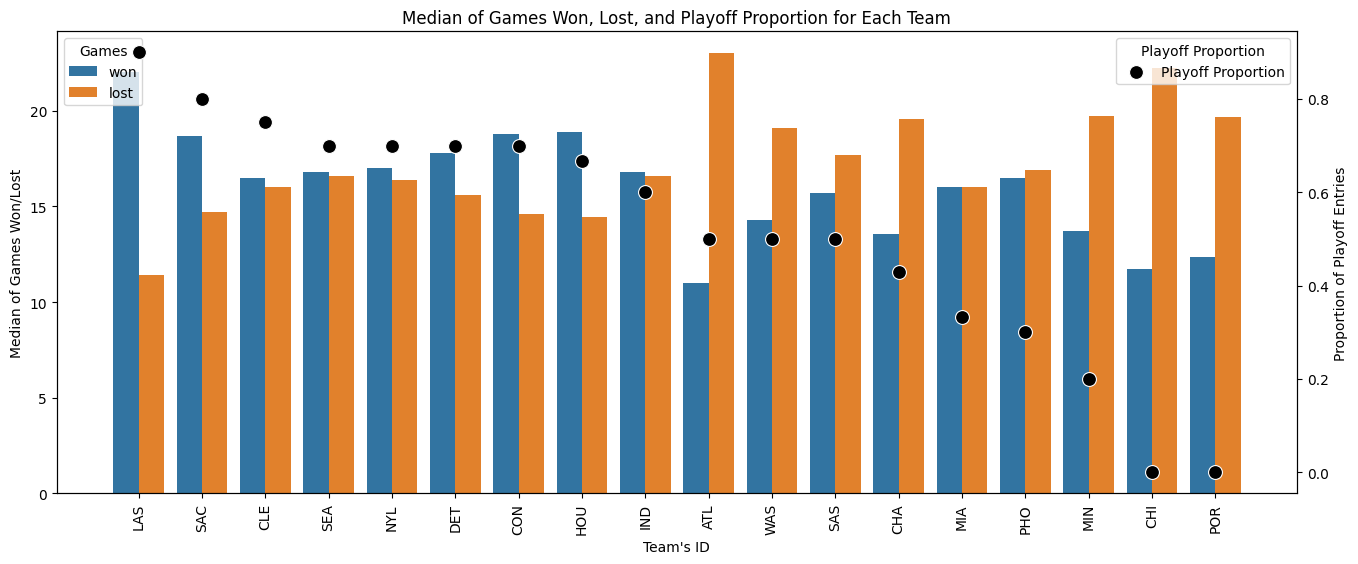

In [3]:
def teams_relation_won_lost_playoff_team(data):
    
    data = teams.groupby('franchID').agg(won=('won','mean'), lost=('lost','mean'), playoff_proportion=('playoff', lambda x: (x == 'Y').sum() / len(x)))
    data = data.reset_index()
    data = data.sort_values(by='playoff_proportion', ascending=False)
    data_games = data.melt(id_vars='franchID', value_vars=['won','lost'], var_name='Result', value_name='Median')

    fig, ax1 = plt.subplots(figsize=(16,6))
    
    sns.barplot(x='franchID', y='Median', hue='Result', data=data_games, ax=ax1)
    ax1.set_xlabel("Team's ID")
    ax1.set_ylabel("Median of Games Won/Lost")
    ax1.set_title("Median of Games Won, Lost, and Playoff Proportion for Each Team")
    ax1.tick_params(axis='x', rotation=90)
    ax2 = ax1.twinx()
    
    sns.scatterplot(x='franchID', y='playoff_proportion', data=data, ax=ax2, color='black', marker='o', s=100)
    ax2.set_ylabel("Proportion of Playoff Entries")
    ax1.legend(loc='upper left', title='Games')
    ax2.legend(['Playoff Proportion'], loc='upper right', title='Playoff Proportion')
    plt.show()

teams_relation_won_lost_playoff_team(teams.copy())

### 1.2 - Relation between year, rank and team (3 features)

There are few teams that seem to have relatively consistent results over the years, which shows that perhaps the results obtained in the previous year's series do not have much relevance to the result of the current year.

For example, while teams like SAC and IND seem to have results that evolve relatively smoothly over the years, teams like DET and WAS are much more irregular.

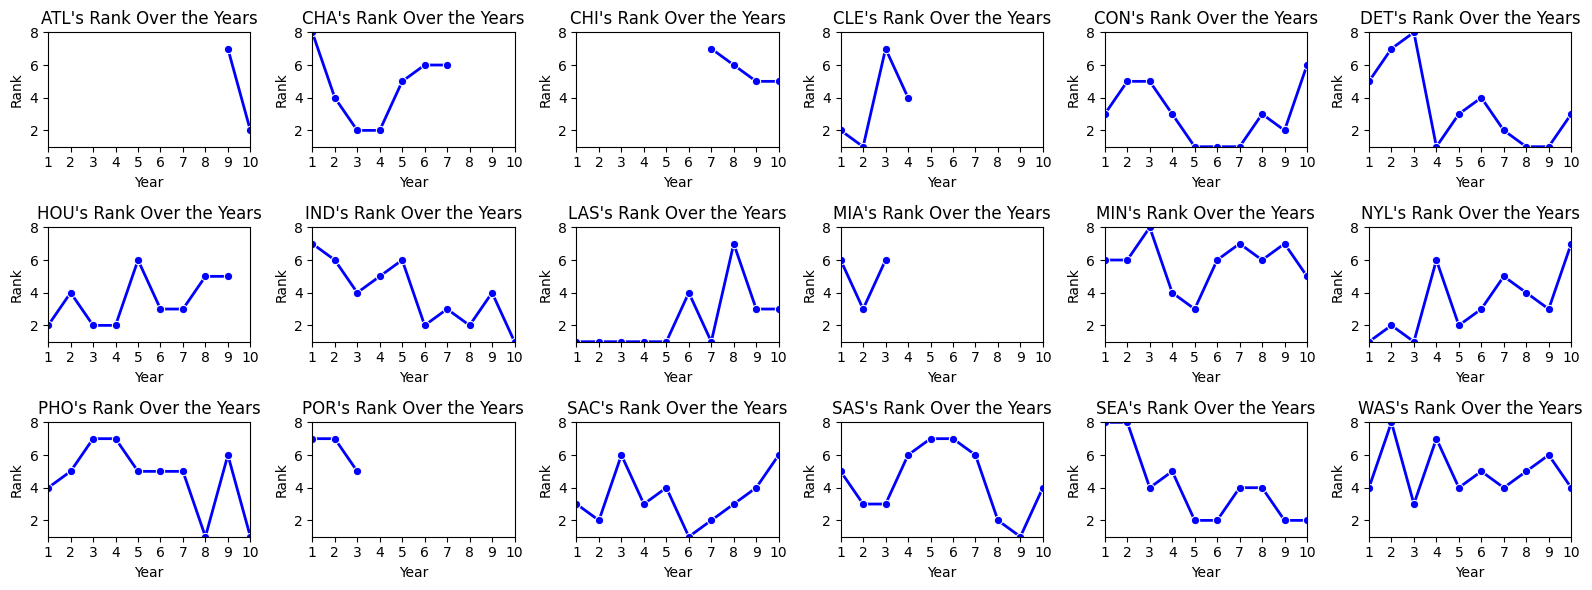

In [4]:
def teams_relation_year_rank_team(data):
    
    data = data[['year','franchID','rank']]
    data = data.sort_values(by=['franchID','year'])
    
    teams = data['franchID'].unique()
    num_teams = len(teams)
    num_cols = 6
    num_rows = (num_teams + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 2 * num_rows ), squeeze=False)

    for idx, team in enumerate(teams):
        
        data_team = data[data['franchID'] == team]        
        ax = axes[idx // num_cols, idx % num_cols]
        sns.lineplot(x='year', y='rank', data=data_team, color='b', marker='o', linewidth=2, ax=ax)
        ax.set_title(f'{team}\'s Rank Over the Years')
        ax.set_xlabel('Year')
        ax.set_ylabel('Rank')        
        ax.invert_yaxis()        
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.set_ylim(1,8)
        ax.set_xlim(1,10)

    for j in range(idx + 1, num_rows * num_cols):
        fig.delaxes(axes[ j // num_cols, j % num_cols])
    
    plt.tight_layout()
    plt.show()

teams_relation_year_rank_team(teams.copy())


### 1.3 - Relation between year, playoff and team (3 features)

Most teams show a certain consistency in qualifying for the playoffs, with rare exceptions.

The most inconsistent teams are the NYL and WAS, as they are the ones with the greatest differences from year to year, i.e., the most peaks in the graph. The other teams show one or two peaks, thus revealing consistency from year to year.

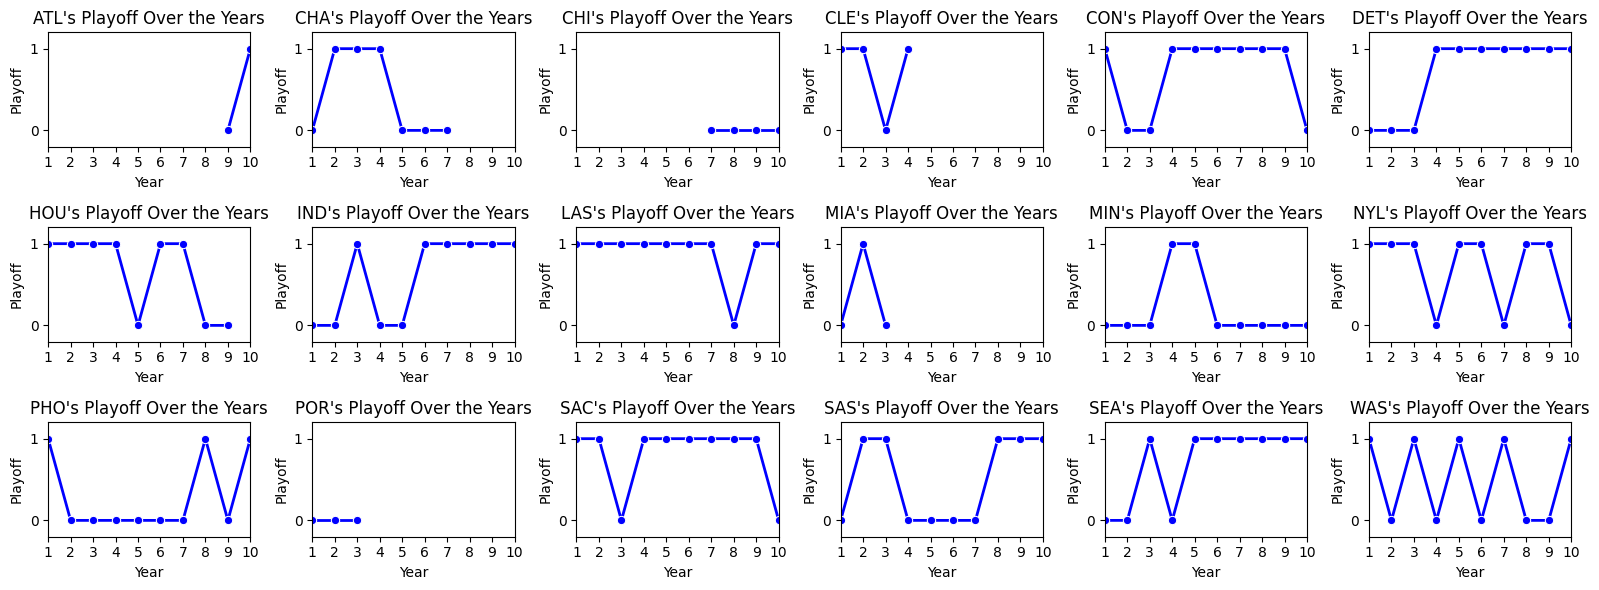

In [5]:
def teams_relation_year_playoff_team( data ):

    data['playoff_numeric'] = data['playoff'].map({'Y': 1, 'N': 0})
    data = data[['year','franchID','playoff_numeric']]
    data = data.sort_values(by=['franchID','year'])

    teams = data['franchID'].unique()
    num_teams = len(teams)
    num_cols = 6
    num_rows = (num_teams + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 2 * num_rows), squeeze=False)

    for idx, team in enumerate(teams):

        data_team = data[data[ 'franchID' ] == team]
        ax = axes[idx // num_cols, idx % num_cols]
        sns.lineplot(x='year', y='playoff_numeric', data=data_team, color='b', marker='o', linewidth=2, ax=ax )
        ax.set_title(f'{team}\'s Playoff Over the Years')
        ax.set_xlabel('Year')
        ax.set_ylabel('Playoff')
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.set_ylim(-0.2,1.2)
        ax.set_yticks([0,1])
        ax.set_xlim(1,10)

    for j in range(idx + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

    plt.tight_layout()
    plt.show()

teams_relation_year_playoff_team(teams.copy())

### 1.4 - Relation between median of attend, median of rank and team (3 features)

There doesn't seem to be much of a relationship between the ranking and the team's assist numbers. Neither the teams with the highest reaking have higher assist numbers, nor the teams with the lowest have lower assist levels,

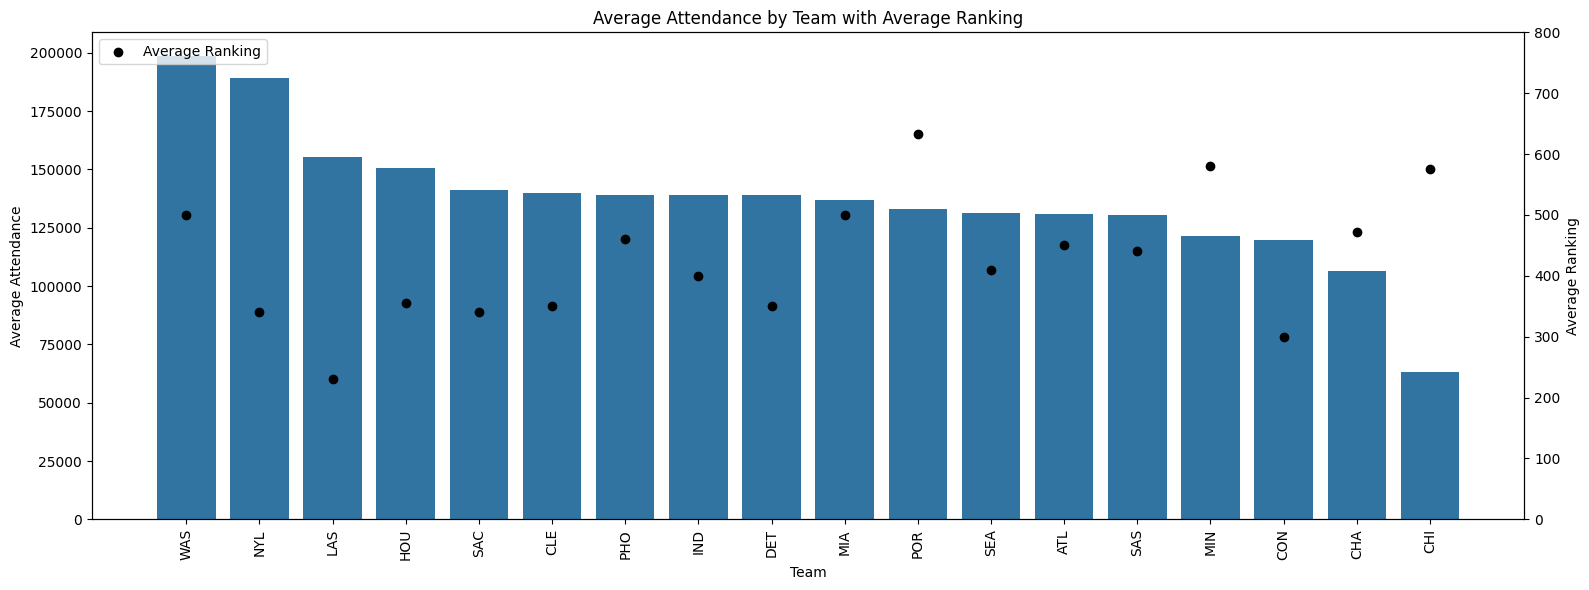

In [6]:
def teams_relation_attend_rank_team(data):

    data = data.groupby('franchID')[['attend','rank']].mean()
    data = data.reset_index()
    data = data.sort_values( by='attend', ascending=False)
    plt.figure(figsize=(16,6))
    sns.barplot(x='franchID', y='attend', data=data)
    plt.title('Average Attendance by Team with Average Ranking')
    plt.xlabel('Team')
    plt.ylabel('Average Attendance')
    plt.xticks(rotation=90)
    ax2 = plt.gca().twinx()
    ax2.scatter(x=data['franchID'], y=data['rank'] * 100, color='black', label='Average Ranking', marker='o')    
    ax2.set_ylabel('Average Ranking', color='black')
    ax2.set_ylim(0,800)
    ax2.tick_params(axis='y', labelcolor='black')

    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

teams_relation_attend_rank_team(teams.copy())


### 1.5 - Relation between games won, games lost, and team (3 features)

Using graphs such as scatter boxes, we can observe the variation in the number of games won and lost by each team in different years.

You can see that there are some that are quite consistent. However, one of the teams with the greatest variation is LAS, which, from the previous graphs, we saw in year 8, unlike all other years, was not selected to go to the playoffs

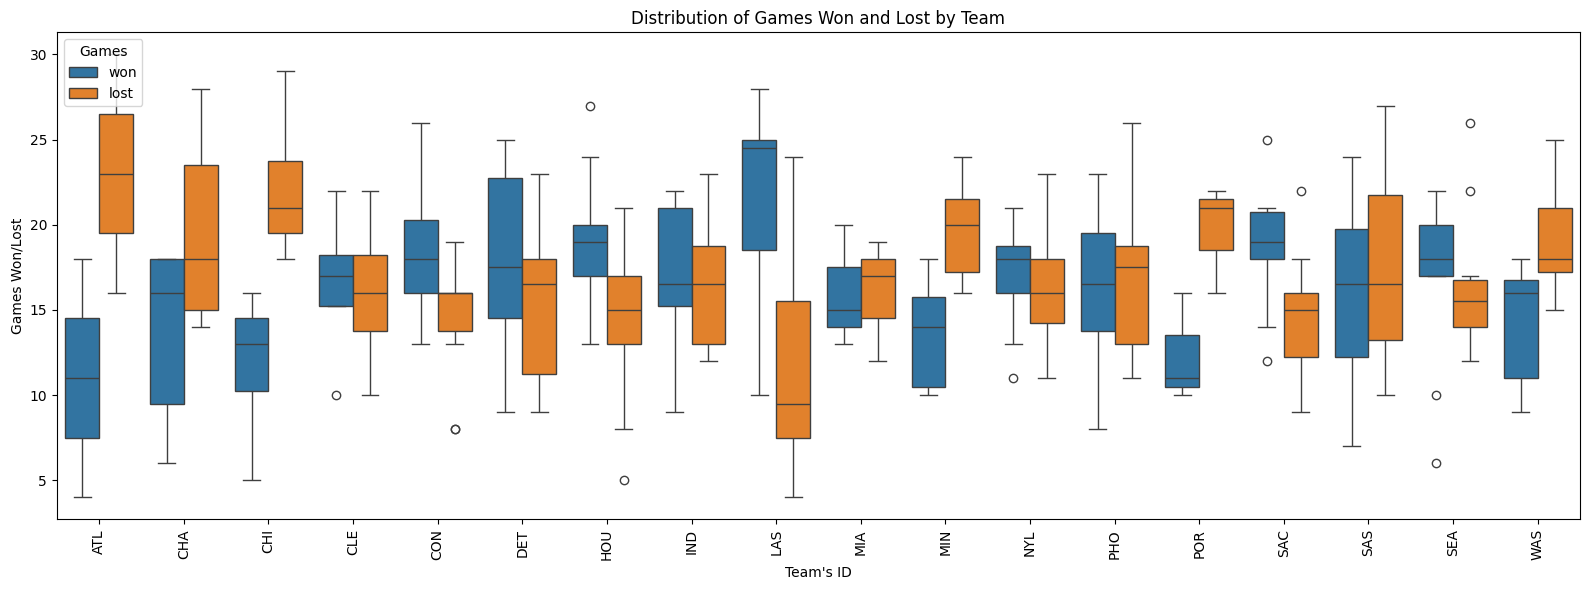

In [7]:
def teams_relation_won_lost_team(data):

    data_agg = data.groupby('franchID').agg(won=('won','mean'), lost=('lost','mean'), playoff_proportion=('playoff', lambda x: (x == 'Y').sum() / len(x))).reset_index()
    data_agg = data_agg.sort_values(by='playoff_proportion', ascending=False)
    data_games = data.melt(id_vars='franchID', value_vars=['won','lost'], var_name='Result', value_name='Games')

    plt.figure(figsize=(16,6))    
    sns.boxplot(x='franchID', y='Games', hue='Result', data=data_games, dodge=True)
    plt.xlabel("Team's ID")
    plt.ylabel("Games Won/Lost")
    plt.title("Distribution of Games Won and Lost by Team")
    plt.legend(loc='upper left', title='Games')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

teams_relation_won_lost_team(teams.copy())


### 1.6 - Correlation between features and playoffs

The features are not very correlated with the playoff attribute, with some having almost no correlation and therefore probably not being very relevant to our predictive algorithm.

In [8]:
def teams_heatmap_playoff(data,limit_down,limit_up):
      
    le = LabelEncoder()
    for col in data.select_dtypes(include=['object']):
        data[col] = le.fit_transform(data[col])

    correlation = data.corr()['playoff'].drop('playoff')
    correlation_filtered = correlation[(correlation >= limit_down) & (correlation <= limit_up)].sort_values()
    heatmap = correlation_filtered.to_frame().T

    if heatmap.empty:
        print("No attributes found with correlation in the specified range.")
        return

    plt.figure(figsize=(16,4))
    sns.heatmap(heatmap, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={ "shrink": .8, "ticks": np.arange(-1, 1.1, 0.1)}, center = 0, vmin = -1 , vmax = 1)
    plt.title( f'Correlation between {limit_down} and {limit_up}', fontsize=16)    
    plt.yticks(rotation=0)
    plt.show()

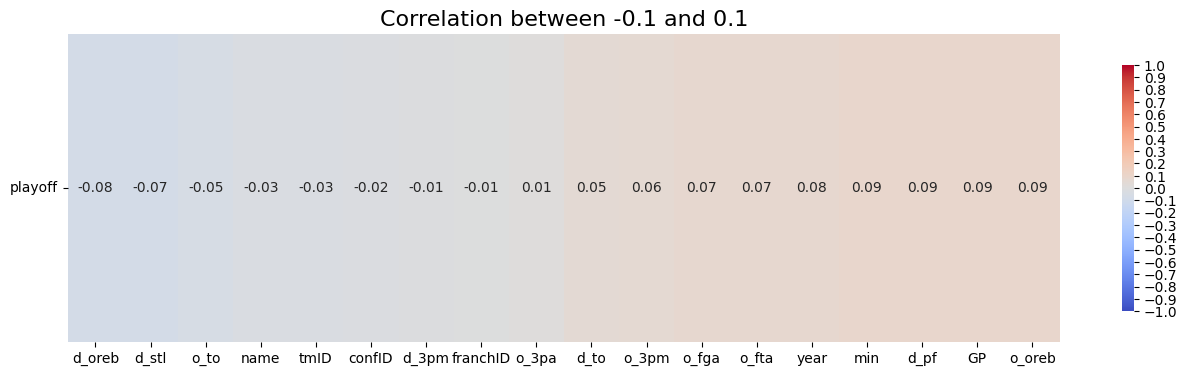

In [9]:
teams_heatmap_playoff(teams.copy(), -0.1, 0.1)

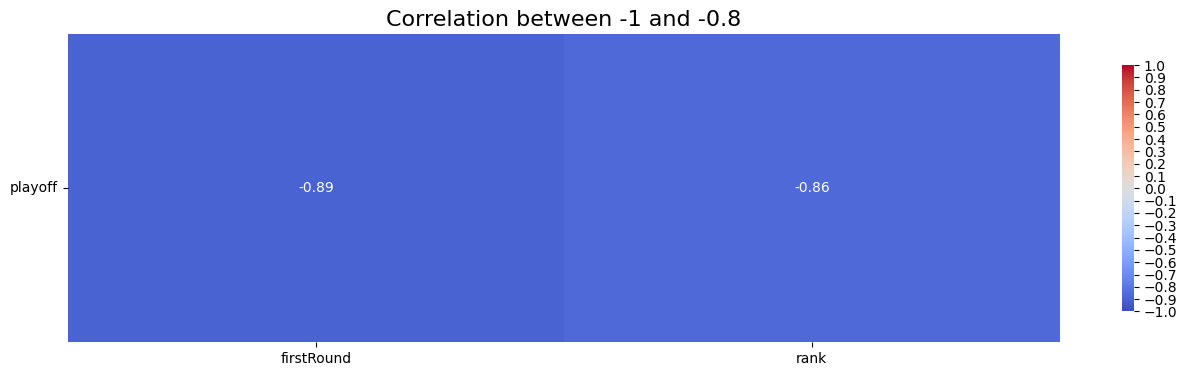

In [10]:
teams_heatmap_playoff(teams.copy(), -1, -0.8)

In [11]:
teams_heatmap_playoff(teams.copy(), 0.8, 1)

No attributes found with correlation in the specified range.


## 2 - Analysing teams_post.csv

### 2.1 - Relation between median of games lost and won, and the team (3 features)

The relationship between the percentage of times a team was selected for the playoffs is not related to its performance in that same phase.

One of the most notorious examples is that of PHO, which despite having a low percentage of passage to the playoffs, when it participated it achieved good results, having the best average number of games won. On the other hand, teams like LAS, CON and SAC, which have the highest passing percentages, are not even close to the teams with the best winning average.

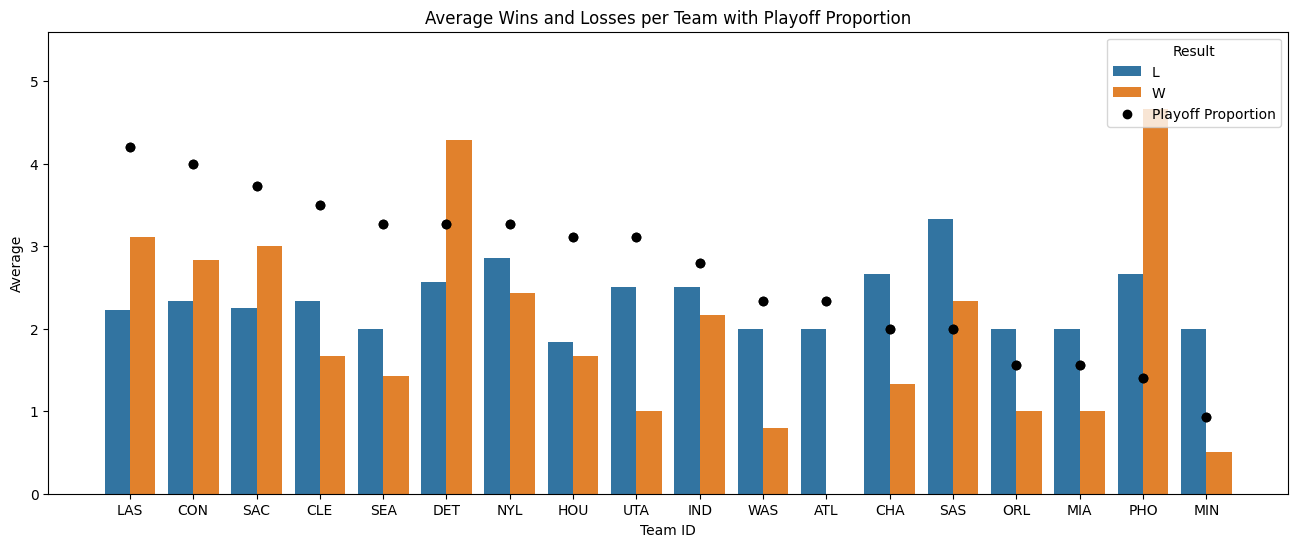

In [12]:
def teams_post_relation_lost_won_teams(data):

    data = data.groupby('tmID')[ ['W','L'] ].mean()
    data = data.reset_index()
    data = data.melt( id_vars='tmID', value_vars=['W','L'], var_name='Result', value_name='Average')

    data_playoff = teams.groupby('tmID')['playoff'].value_counts(normalize=True).unstack().fillna(0)
    data_playoff = data_playoff['Y'].reset_index()
    data_playoff.columns = ['tmID','Playoff_Proportion']

    data = pd.merge(data, data_playoff, on='tmID', how ='left')
    data = data.sort_values(by="Playoff_Proportion", ascending=False)

    plt.figure(figsize=(16,6))
    sns.barplot(x='tmID', y='Average', hue='Result', data=data)

    for index, row in data.iterrows():
        plt.scatter(row['tmID'], row['Playoff_Proportion'] * (data['Average'].max()), color='black', label='Playoff Proportion' if index == 0 else "")
    
    plt.title('Average Wins and Losses per Team with Playoff Proportion')
    plt.xlabel('Team ID')
    plt.ylabel('Average')
    plt.legend(title='Result', loc='upper right')
    plt.xticks(rotation=0)
    plt.ylim(0, data['Average'].max() * 1.2)
    plt.show()

teams_post_relation_lost_won_teams(teams_post.copy())

## 3 - Analysing series_post.csv

### 3.1 - Relation between winners and teams (2 features)

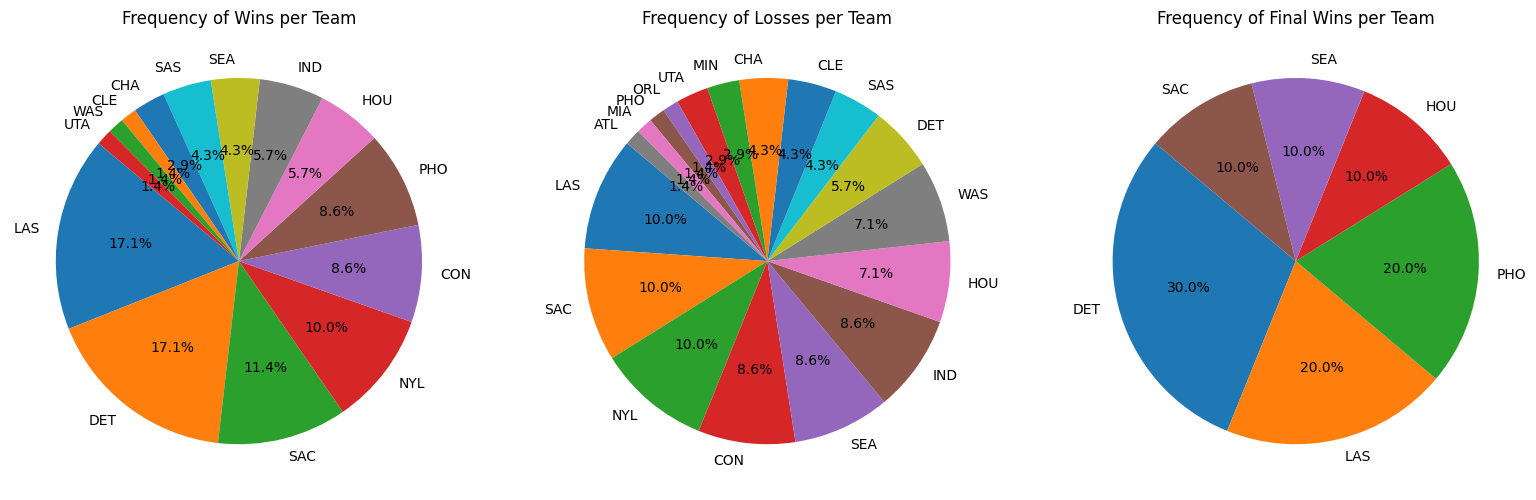

In [13]:
def series_post_relation_winner_team(data):

    plt.figure(figsize=(16,5))

    winner_counts = data['tmIDWinner'].value_counts().dropna().sort_values(ascending=False)
    plt.subplot(1,3,1)
    plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Frequency of Wins per Team')
    
    loser_counts = data['tmIDLoser'].value_counts().dropna().sort_values(ascending=False)
    plt.subplot(1,3,2)
    plt.pie(loser_counts, labels=loser_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Frequency of Losses per Team')

    winner_g_counts = data[data['series'] == 'G']['tmIDWinner'].value_counts().dropna().sort_values(ascending=False)
    plt.subplot(1,3,3)
    plt.pie(winner_g_counts, labels=winner_g_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Frequency of Final Wins per Team')

    plt.tight_layout()
    plt.show()

series_post_relation_winner_team(series_post.copy())

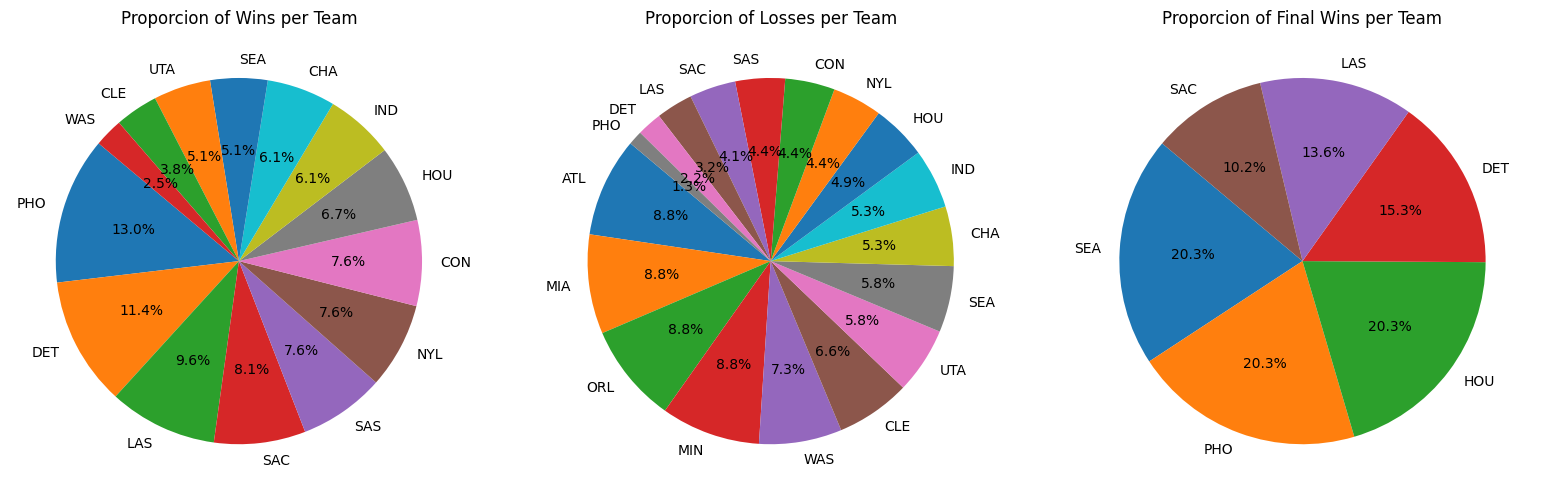

In [14]:
def series_post_relation_winner_median_team(data):
    
    plt.figure(figsize=(16,5))
    
    winner_appearances = data['tmIDWinner'].value_counts()
    loser_appearances = data['tmIDLoser'].value_counts()
    total_appearances = winner_appearances.add(loser_appearances, fill_value=0)
    
    final_winner_appearances = data[data['series'] == 'G']['tmIDWinner'].value_counts()
    final_loser_appearances = data[data['series'] == 'G']['tmIDLoser'].value_counts()
    final_total_appearances = final_winner_appearances.add( final_loser_appearances, fill_value=0)

    winner_counts = (winner_appearances / total_appearances).fillna(0).dropna().sort_values(ascending=False)
    winner_counts = winner_counts[winner_counts > 0]
    plt.subplot(1,3,1)
    plt.pie(winner_counts, labels=winner_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Proporcion of Wins per Team')

    loser_counts = (loser_appearances / total_appearances).fillna(0).dropna().sort_values(ascending=False)
    loser_counts = loser_counts[loser_counts > 0]
    plt.subplot(1,3,2)
    plt.pie(loser_counts, labels=loser_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Proporcion of Losses per Team')

    winner_g_counts = (final_winner_appearances / final_total_appearances).fillna(0).dropna().sort_values(ascending=False)
    winner_g_counts = winner_g_counts[winner_g_counts > 0]
    plt.subplot(1,3,3)
    plt.pie(winner_g_counts, labels=winner_g_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Proporcion of Final Wins per Team')

    plt.tight_layout()
    plt.show()

series_post_relation_winner_median_team(series_post.copy())

## 4 - Analysing coaches.csv 

## 5 - Analysing awards_players.csv

## 6 - Analysing players_teams.csv

## 7 - Analysing players.csv